In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
from glob import glob
import ultralytics
from ultralytics import YOLO
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models


In [6]:
class CustomResNet(nn.Module): # CustomResNet은 nn.Module 상속
  def __init__(self, in_channels=3):
    super(CustomResNet, self).__init__()

    # torchvision.models에서 사전훈련된 resnet 모델 가져오기
    self.model = models.resnet50(pretrained=True)
    
    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # 1000개 클래스 대신 34개 클래스로 바꿔주기
    num_ftrs = self.model.fc.in_features
    # nn.Linear(in_features, out_features ...)
    self.model.fc = nn.Linear(num_ftrs, 34)

  def forward(self, x): # 모델에 있는 foward 함수 그대로 가져오기
    return self.model(x)

In [10]:
yoloModel = YOLO('/content/drive/MyDrive/USG/yolobest.pt')

In [11]:
resnetModel = CustomResNet().to(device)
model_state_dict = torch.load("/content/drive/MyDrive/USG/resnet.pt")
resnetModel.load_state_dict(model_state_dict)
test_imgs = glob(f'/content/drive/MyDrive/USG/test1/*')

<All keys matched successfully>

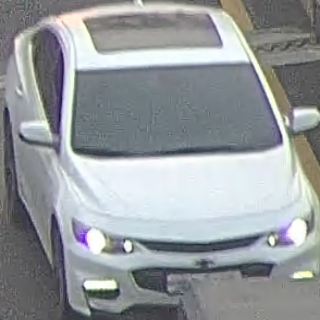

tensor([30]) 1


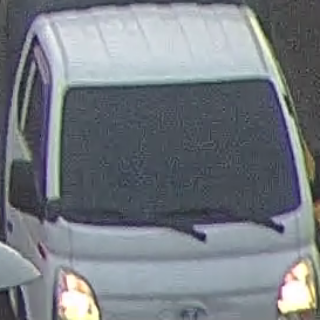

0: 384x640 1 chevrolet_malibu_sedan_2017_2019, 1 kia_morning_hatchback_2004_2010, 125.6ms
Speed: 15.4ms preprocess, 125.6ms inference, 31.2ms postprocess per image at shape (1, 3, 640, 640)


tensor([28]) 22


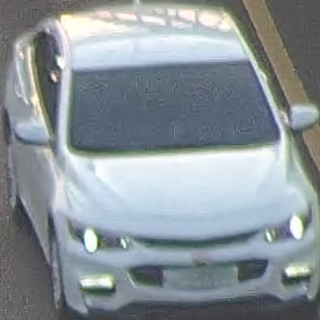

0: 384x640 1 chevrolet_malibu_sedan_2017_2019, 1 hyundai_avante_sedan_2020_, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


tensor([29]) 1


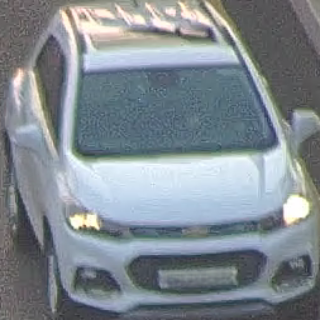

0: 384x640 1 chevrolet_trax_suv_2017_2019, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


tensor([31]) 4


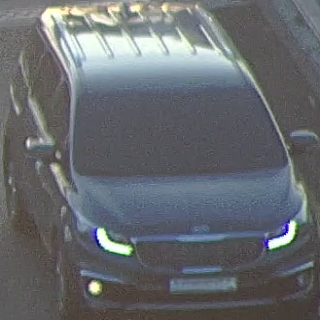

0: 384x640 1 kia_carnival_van_2015_2020, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


tensor([2]) 16


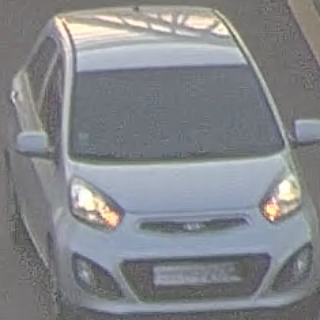

0: 384x640 1 kia_morning_hatchback_2011_2016, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


tensor([13]) 23


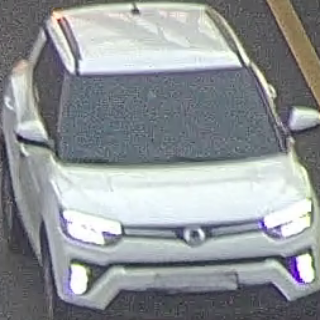

0: 384x640 1 ssangyong_tivoli_suv_2016_2020, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


tensor([33]) 33


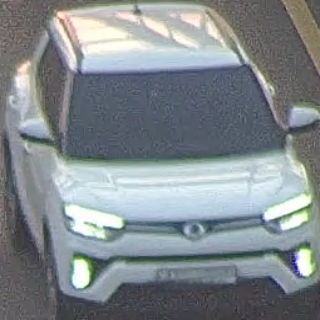

0: 384x640 1 ssangyong_tivoli_suv_2016_2020, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


tensor([10]) 33



0: 384x640 (no detections), 7.4ms
Speed: 3.5ms preprocess, 7.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)



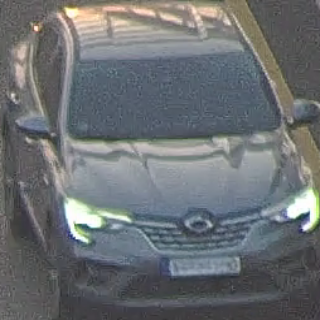

0: 384x640 1 renault_xm3_suv_2020_, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


tensor([31]) 31


ValueError: ignored

In [19]:
submit_csv = pd.read_csv('./sample_submission.csv')
for i, path in enumerate(test_imgs):
  file_name = path.split('/')[-1]
  img = cv2.imread(path, cv2.IMREAD_COLOR)
  #height, width, channel = img.shape

  results = yoloModel(img, stream=True)
  for result in results:
    class_id = result.boxes.cls.int().tolist()
    N = len(class_id)
    if(N):
      boxes = result.boxes.xyxy.int().tolist()
      conf = result.boxes.conf.tolist()
      
      # 가로등 또는 오토바이 탐지 시 resnet으로 넘기면 안된다.
      tmp1, tmp2, tmp3 = [],[],[]
      for idx in range(N):
        ## xyxy[0] : 좌상 x, xyxy[1] : 좌상 y, xyxy[2] : 우하 x, xyxy[3] : 우하 y
        xyxy = boxes[idx]
        if np.abs(xyxy[2] - xyxy[0]) > 120 and np.abs(xyxy[3] - xyxy[1]) > 120:
          tmp1.append(class_id[idx])
          tmp2.append(boxes[idx])
          tmp3.append(conf[idx])
      class_id = tmp1
      boxes = tmp2
      conf = tmp3
      
    
      # 하나의 객체에 대해 중복되는 박스를 하나만 남긴다.
      tmp1 = []
      rem = []
      for p in np.arange(len(class_id)):
        for q in np.arange(p+1, len(class_id)):
          if np.abs(boxes[p][0]-boxes[q][0]) < 50 and np.abs(boxes[p][1] - boxes[q][1]) < 50:
            tmp1.append([class_id[q], boxes[q], conf[q]])
      for item in tmp1:
        class_id.remove(item[0])
        boxes.remove(item[1])
        conf.remove(item[2])
      for j, xyxy in enumerate(boxes):
        x1, y1, x2, y2 = xyxy
        confidence = conf[j]
        imgToResnet = img[y1:y2, x1:x2]
        imgToResnet = cv2.resize(imgToResnet, (320,320), cv2.INTER_LINEAR)
        cv2_imshow(imgToResnet)
        imgToResnet = torch.Tensor(imgToResnet).permute(2,0,1).unsqueeze(0) 
        
        with torch.no_grad():
            resnetModel.eval()
            output = resnetModel(imgToResnet.to(device))
            _, predicted_class = torch.max(output, 1)

            print(predicted_class.to('cpu'), class_id[j])
            submit_csv = pd.concat([ 
                submit_csv,
                pd.DataFrame.from_dict([{
                "file_name":file_name,
                "class_id": predicted_class.cpu().int().numpy()[0],
                "confidence": confidence,
                "point1_x":x1, "point1_y":y1,
                "point2_x":x2, "point2_y":y1,
                "point3_x":x2, "point3_y":y2,
                "point4_x":x1, "point4_y":y2,
            }])
                ], ignore_index=True)

  
  """if i == 10:
    break"""

